# SVM Implementation with CVXOPT
https://towardsdatascience.com/support-vector-machines-for-classification-fc7c1565e3

This is a soft margin implementation of the SVM dual problem to deal with data that is not completely separable, which is reflective of real life data. We include a tolerance variable C which modifies the constraints with an upperbound on alphas. We have the following optimization objective and constraints

$$
L(\mathbf \alpha)=\sum_{n=1}^N \alpha_n-\frac 1 2 \sum_{m=1}^N\sum_{n=1}^N\alpha_m\alpha_n y_m y_n k(\mathbf x_m, \mathbf x_n)
$$

$$
\large {0 \le \alpha_n \le C,\quad \sum_{n=1}^N \alpha_n y_n = 0}
$$


The kernel function $k(\mathbf x_m, \mathbf x_n)$ can be chosen for a linear kernel or radial basis function (RBF) kernel, kernels of which respecitvely are given by

$$\large { k(\mathbf x, \mathbf x')=\mathbf{x^\intercal}\mathbf x',\quad k(\mathbf x, \mathbf x')=\exp\left(-\gamma\|{\mathbf x-\mathbf x'}\|^2\right)}$$

## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from cvxopt import matrix, solvers
from sklearn.svm import SVC

parameters = {}
KERNEL_LINEAR = 1
KERNEL_RBF = 2

DATASET_LINEARLY_SEPARABLE = 1  
# Generate a linearly separable dataset
DATASET_CIRCULAR = 2  
# Generate a non-linearly separable dataset that is 
# distributed as a circle around the centre.

## generate data

In [4]:
def generate_data(dataset):
    n = 2000
    X = np.random.rand(n, 2)
    y = np.zeros((n,))
    noise = np.random.uniform(-0.05, 0.05, n)
    
    if dataset == DATASET_LINEARLY_SEPARABLE:
        for i in range(n):
            x1 = X[i][0]
            x2 = X[i][1] + noise[i]
            y[i] = 1.0 if x2 <= 1.0 * x1 else -1.0
    else:
        r = 0.3
        centre = np.array([0.5, 0.5])

        for i in range(n):
            dist = np.linalg.norm(X[i] - centre) + noise[i]
            y[i] = 1.0 if dist <= r else -1.0
        
    parameters['X'] = X
    parameters['y'] = y
    
    return X, y
        

## Linear

### visualize dataset

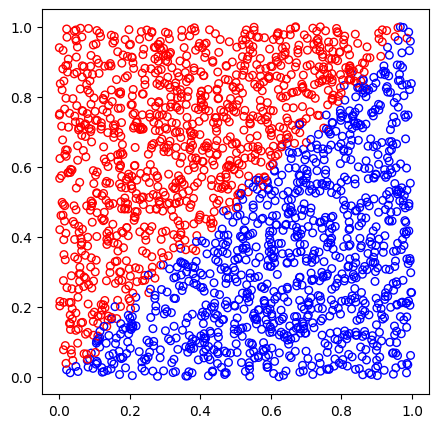

In [13]:
X, y = generate_data(DATASET_LINEARLY_SEPARABLE)
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=30)
plt.show()

### populate k (Kernel/Gram matrix)

In [14]:
def gram_matrix(X, Y, kernel_type, gamma=0.5):
    K = np.zeros((X.shape[0], Y.shape[0]))
    
    if kernel_type == KERNEL_LINEAR:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.dot(x.T, y)
                
    elif kernel_type == KERNEL_RBF:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.exp(-gamma * np.linalg.norm(x - y) ** 2)
        
    return K

We must turn the dual problem into a minimization objective and convert everything into matrix form

$$
L_{min}(\mathbf \alpha)=\frac 1 2 \sum_{m=1}^N\sum_{n=1}^N\alpha_m\alpha_n y_m y_n k(\mathbf x_m, \mathbf x_n) - \sum_{n=1}^N \alpha_n
$$

$$
= \frac{1}{2} \alpha^{\intercal} \mathbf{H} \alpha - {1}^\intercal \alpha
$$

$$
\text{such that} \quad \large {-\alpha_n \le 0 \alpha_n \le C \mathbf{y}^\intercal \alpha = 0}
$$

    

We need the following matrices


$$P_{N \times N}=H_{N \times N}=\left(\mathbf{y}^{\top} \mathbf{y}\right) * K(\mathbf{X}, \mathbf{X}) \\
q_{N \times 1}=-\left(\begin{array}{c}
1 \\
1 \\
1 \\
\vdots \\
\vdots \\
1
\end{array}\right) 
$$

$$
G_{2 N \times N}=\left(\begin{array}{ccccc}
-1 & 0 & 0 & \vdots & \\
0 & -1 & & & \\
0 & & -1 & & \\
0 & & & -1 & \\
\vdots & & & & -1 \\
1 & 0 & 0 & \vdots & \\
0 & 1 & & & \\
0 & & 1 & & \\
0 & & & 1 & \\
\vdots & & & & 1
\end{array}\right)
$$

$$
h_{2 N \times 1}=\left(\begin{array}{c}
0 \\
0 \\
0 \\
\vdots \\
\vdots \\
C \\
C \\
C \\
\vdots \\
\vdots
\end{array}\right)
$$

$$
A_{N \times 1}=\mathbf{y} b=[0]
$$

### train the model

In [15]:
def train_svm(kernel):
    C = 100
    n, k = X.shape
    
    y_matrix = y.reshape(1, -1)
    H = np.dot(y_matrix.T, y_matrix) * gram_matrix(X, X, kernel)
    P = matrix(H)
    q = matrix(-np.ones((n, 1)))
    G = matrix(np.vstack((-np.eye((n)), np.eye(n))))
    h = matrix(np.vstack((np.zeros((n,1)), np.ones((n,1)) * C)))
    A = matrix(y_matrix)
    b = matrix(np.zeros(1))
    
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10

    return solvers.qp(P, q, G, h, A, b)

In [16]:
X = parameters['X']
svm_parameters = train_svm(KERNEL_LINEAR)
print(svm_parameters)

     pcost       dcost       gap    pres   dres
 0:  5.3649e+03 -1.3303e+07  3e+07  7e-01  6e-13
 1:  1.0389e+05 -3.6123e+06  5e+06  8e-02  5e-13
 2:  1.0905e+05 -4.7963e+05  7e+05  9e-03  7e-13
 3:  2.4113e+04 -9.6445e+04  1e+05  9e-04  3e-13
 4:  2.4083e+02 -3.8807e+04  4e+04  2e-04  3e-13
 5: -2.5988e+03 -3.3187e+04  3e+04  2e-04  3e-13
 6: -5.7159e+03 -2.6273e+04  2e+04  9e-05  3e-13
 7: -6.9113e+03 -2.4018e+04  2e+04  7e-05  3e-13
 8: -7.9276e+03 -2.1969e+04  1e+04  5e-05  3e-13
 9: -8.6512e+03 -2.0688e+04  1e+04  4e-05  3e-13
10: -9.2739e+03 -1.9523e+04  1e+04  3e-05  3e-13
11: -9.9106e+03 -1.8210e+04  8e+03  2e-05  3e-13
12: -1.0325e+04 -1.7410e+04  7e+03  2e-05  3e-13
13: -1.0685e+04 -1.6752e+04  6e+03  1e-05  3e-13
14: -1.0918e+04 -1.6284e+04  5e+03  9e-06  3e-13
15: -1.1274e+04 -1.5599e+04  4e+03  6e-06  3e-13
16: -1.1493e+04 -1.5200e+04  4e+03  4e-06  3e-13
17: -1.1804e+04 -1.4666e+04  3e+03  3e-06  3e-13
18: -1.2139e+04 -1.4089e+04  2e+03  2e-06  3e-13
19: -1.2287e+04 -1.37

### optimal parameters
$$\large{\mathbf{w} = \mathbf{X}^T \alpha \mathbf{y}}$$
$$\large{b = (\mathbf{y} - \mathbf{X}\mathbf{w}) \in \mathbb S}$$

Where $\mathbb S$ is the support vector subset

In [17]:
def get_parameters(alphas):
    threshold = 1e-5 # Values greater than zero (some floating point tolerance)
    S = (alphas > threshold).reshape(-1, )
    w = np.dot(X.T, alphas * y)
    b = y[S] - np.dot(X[S], w) # b calculation
    b = np.mean(b)
    return w, b, S

alphas = np.array(svm_parameters['x'])[:, 0]
w, b, S = get_parameters(alphas)

print('Alphas:', alphas[S][0:20])
print('w and b', w, b)

Alphas: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]
w and b [ 31.48446079 -31.76469381] 0.10491053629047564


### display distribution with support vectors

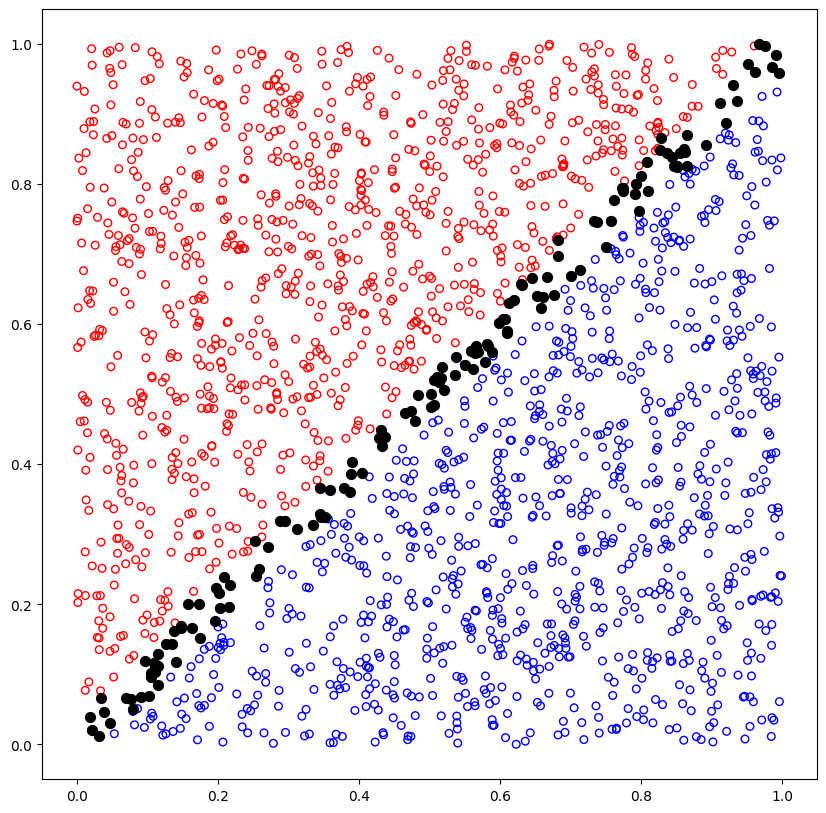

In [18]:
def sv_graph():
    support_vectors = X[S]

    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=30)
    ax.scatter(support_vectors[:,0], support_vectors[:,1], c='black', s=50)
    plt.show()
    
sv_graph()

## Radial

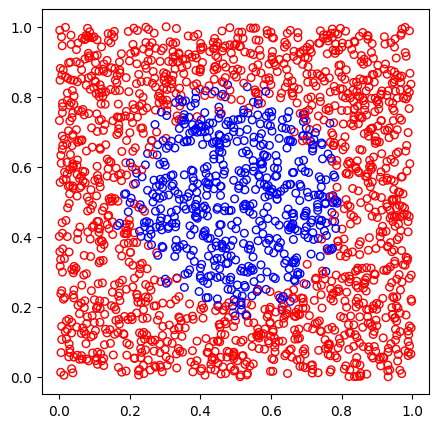

In [19]:
X, y = generate_data(DATASET_CIRCULAR)
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=30)
plt.show()